## Assignment 3
### Liu Yefeng
### yl520@duke.edu

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
import os
import skimage.filters as filters
from time import gmtime, strftime, sleep
from scipy import interpolate as interp
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0)

/Users/yeko/anaconda/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [100]:
def grabImage(sid=1, imres=8, fm=1, cameraNumber=8):
    cmdA='ssh ubuntu@10.0.1.'+str(cameraNumber)
    cmdB='scp ubuntu@10.0.1.'+str(cameraNumber)
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm *raw', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 --dump-bayer\
                    --file-name dbGrab --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':*.raw .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    if fm==1:
        fileName = re.search(r'dbGrab(.*).jpg', rePop)
        fileName=fileName.group()
        pop=imio.imread(fileName)
    else:
        fileName = re.search(r'(.*).raw', rePop)
        fileName=fileName.group()
        pop=np.fromfile(fileName,dtype=np.dtype('i2'))
        pop=pop[28672:]
        pop=np.reshape(pop,(2160,3840))
        #pop=np.append(pop[:,2060:] ,pop[:,:2060],axis=1)
    return pop

def adjustColor(inputImage,rc=1,bc=1,gc=1,gain=1,contrast=1):
    fI=inputImage.astype(np.float)
    fI[:,:,0]=rc*fI[:,:,0]
    fI[:,:,1]=gc*fI[:,:,1]
    fI[:,:,2]=bc*fI[:,:,2]
    fI=gain*fI/np.max(fI)
    fI=255*np.tanh(contrast*fI)
    fI=fI.astype(np.uint8)
    return fI

def move_focus(sid=1, step=0):
    cmD='ssh ubuntu@10.0.1.8 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(step)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

###  Capture raw bayer images of objects of various colors. Identify red, green and blue pixels in the raw images and illustrate how the red green and blue sensor response is different for different objects.

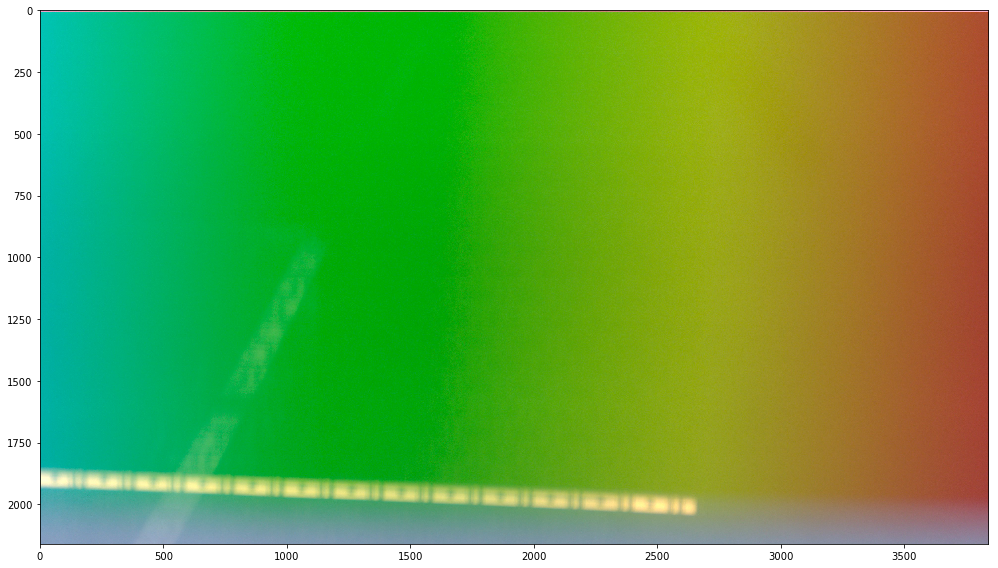

In [15]:
a_jpg = imio.imread('dbGrab_6247_s01_00000.jpg')
imio.imshow(a_jpg)

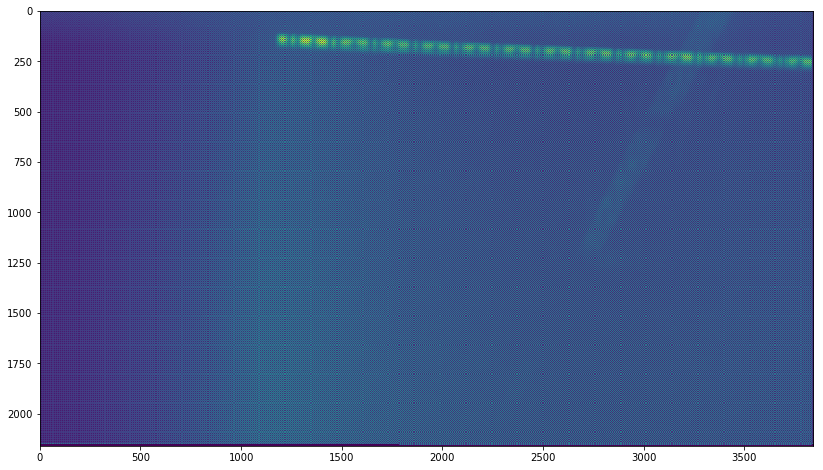

In [10]:
a = grabImage(fm=2)
plt.imshow(a)

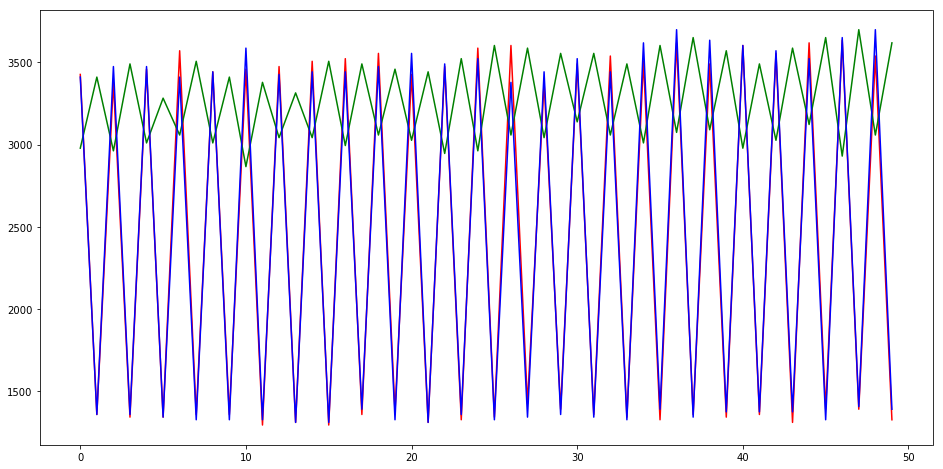

In [13]:
rg=np.arange(50)
plt.plot(rg,a[1851,500+rg],'r',rg,a[1852,500+rg],'g',rg,a[1853,500+rg],'b')

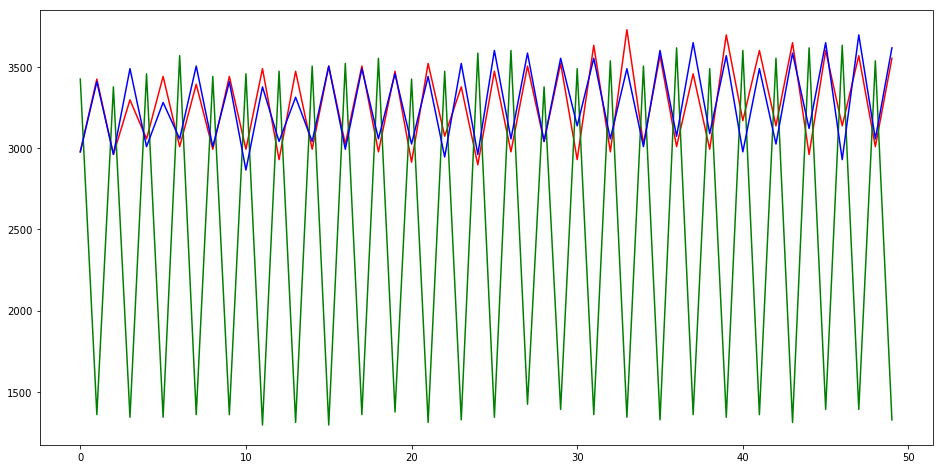

In [14]:
rg=np.arange(50)
plt.plot(rg,a[1850,500+rg],'r',rg,a[1851,500+rg],'g',rg,a[1852,500+rg],'b')

### As discussed in class, the raw data contains one 1920 by 1080 red image, one 1920 by 1080 blue image and 2 1920 by 1080 green image. Form a color image using the the red image the blue image and one of the green images. How does your image look? Can you adjust the color balance, gain and gamma to make it match the actual scene? Compare with a directly captured JPEG image.

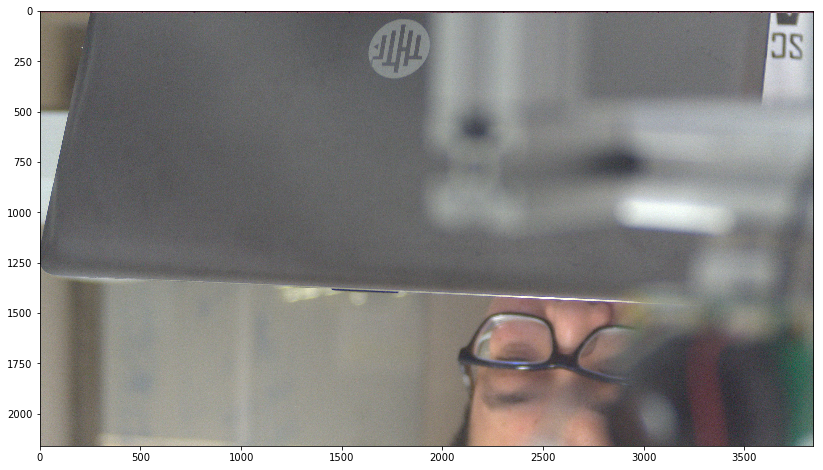

In [95]:
b = grabImage(sid=0,fm=1)
plt.imshow(b)

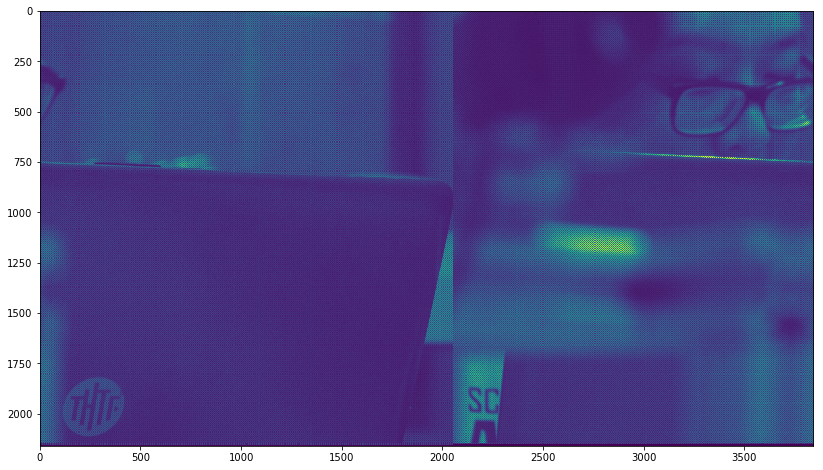

In [96]:
b = grabImage(sid=0,fm=2)
plt.imshow(b)

In [97]:
def demosaic(rawImage):
    red1=rawImage[1:2161:2,0:2048:2]
    red2=rawImage[0:2160:2,2048:3840:2]
    red=np.append(red2 ,red1,axis=1)
    redU=interp.RectBivariateSpline(np.arange(0,1080),np.arange(0,1920),red)
    red=redU(np.arange(0,1080,.5),np.arange(0,1920,.5))
    blue1=rawImage[0:2160:2,1:2049:2]
    blue2=rawImage[1:2161:2,2049:3841:2]
    blue=np.append(blue2 ,blue1,axis=1)
    blueU=interp.RectBivariateSpline(np.arange(0,1080),np.arange(0,1920),blue)
    blue=blueU(np.arange(0,1080,.5),np.arange(0,1920,.5))
    green=rawImage;
    for er in range(1,2159,2):
        for odr in range(0,2050,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    for er in range(0,2160,2):
        for odr in range(1,2049,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    for er in range(0,2160,2):
        for odr in range(2048,3838,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    for er in range(1,2159,2):
        for odr in range(2047,3839,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    green=np.append(green[:,2048:] ,green[:,:2048],axis=1)
    imageOut=np.dstack((red,green,blue))
    imageOut=255*imageOut/np.max(imageOut)
    imageOut=imageOut.astype(np.uint8)
    return imageOut

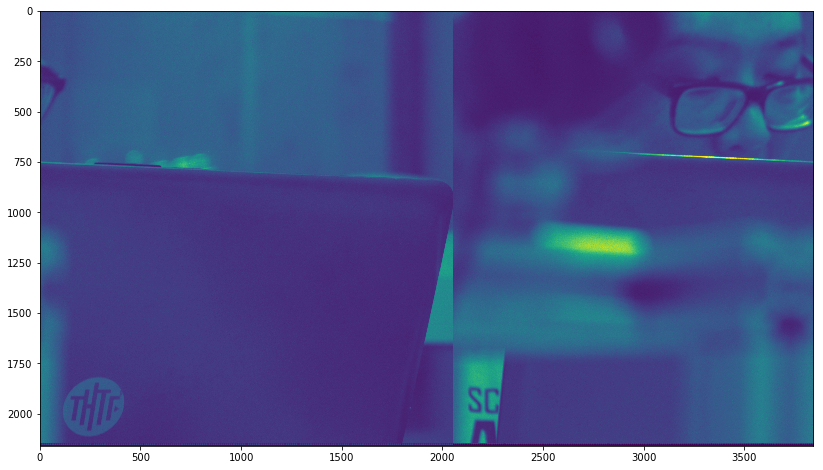

In [98]:
c=demosaic(b)
plt.imshow(b)

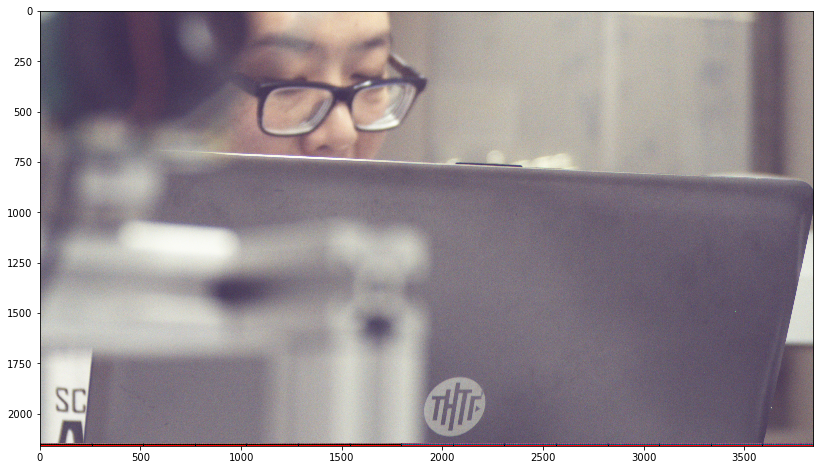

In [129]:
d = adjustColor(c, 1.0, 1.4, 0.70, 1.4, 4)
plt.imshow(d)

### Use the demosaicing algorithm used in class or an alternative similar demosaicing algorithm to form a color image. Take color images of various test targets. Compare the image resolution of the images created by this approach with images processed in question 4

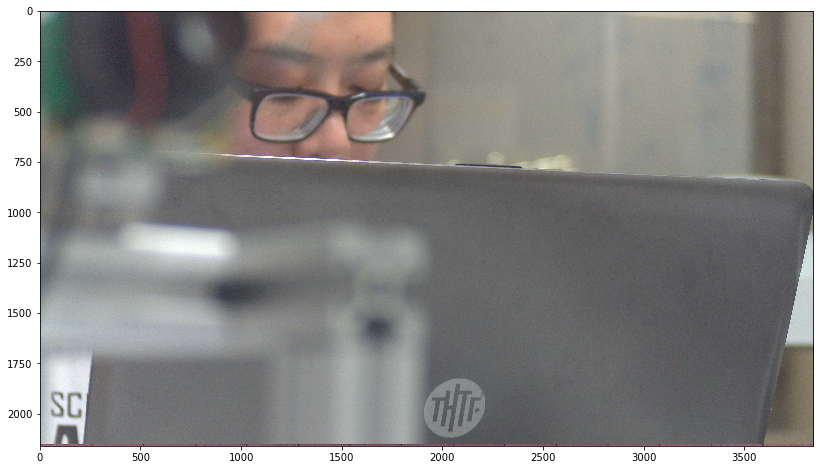

In [105]:
b_jpg=imio.imread('dbGrab_13888_s00_00000.jpg')
b_jpg = trans.rotate(b_jpg, 180)
plt.imshow(b_jpg)

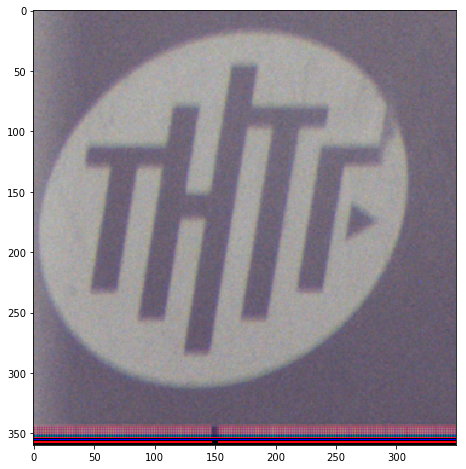

In [138]:
plt.imshow(d[1800:,1900:2250])

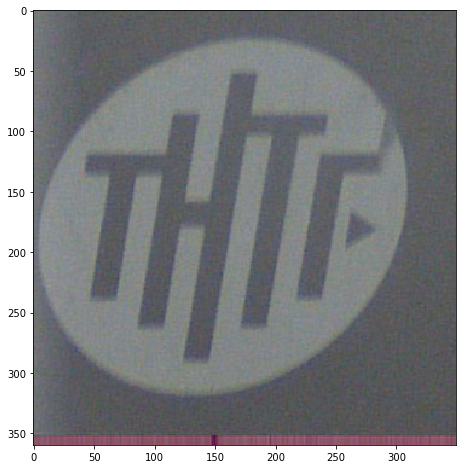

In [137]:
plt.imshow(b_jpg[1800: ,1900:2250])

### The oringinal jpg image has a higher resolution than the converted raw image, the lost of the green layer may be the main reason. Also the edge of the converted raw image is weird due to the linear interpolation